In [40]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
%config InlineBackend.figure_format = 'png'

In [41]:
train = pd.read_csv("input/listings.csv")

In [42]:
train.dtypes

id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
summary                              object
space                                object
description                          object
experiences_offered                  object
neighborhood_overview                object
notes                                object
transit                              object
access                               object
interaction                          object
house_rules                          object
thumbnail_url                        object
medium_url                           object
picture_url                          object
xl_picture_url                       object
host_id                               int64
host_url                             object
host_name                            object
host_since                      

In [43]:
columns_to_keep = ["price", "neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "name", "summary",
                   "amenities", "latitude", "longitude", "number_of_reviews",
                   "require_guest_phone_verification", "minimum_nights"]

train = train[columns_to_keep]

In [44]:
train.dtypes

price                                object
neighbourhood_cleansed               object
bedrooms                            float64
property_type                        object
room_type                            object
name                                 object
summary                              object
amenities                            object
latitude                            float64
longitude                           float64
number_of_reviews                     int64
require_guest_phone_verification     object
minimum_nights                        int64
dtype: object

In [45]:
train.head(3)

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,$250.00,Roslindale,2.0,House,Entire home/apt,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ...",42.282619,-71.133068,0,f,2
1,$65.00,Roslindale,1.0,Apartment,Private room,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.286241,-71.134374,36,f,2
2,$65.00,Roslindale,1.0,Apartment,Private room,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",42.292438,-71.135765,41,f,3


In [46]:
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5) #these are studios
    train["summary"] = train["summary"].fillna("")
    #train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].str.replace("[$,]", "").astype("float")
    #eliminate crazy prices:
    train = train[train["price"] < 600]
    
    return train

In [47]:
train = clean(train)

98.37957922657978

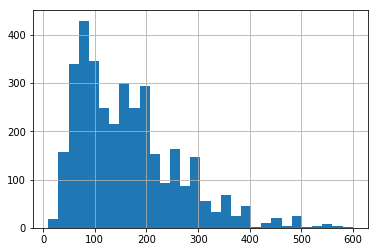

In [48]:
train["price"].hist(bins = 30)
train["price"].std()

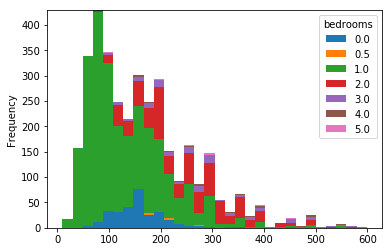

In [49]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = True))

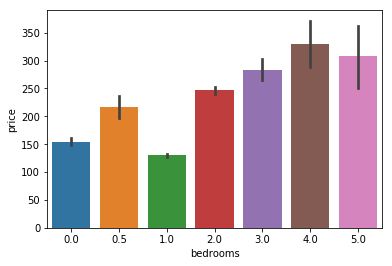

In [50]:
sns.barplot(x = "bedrooms", y = "price", data = train)

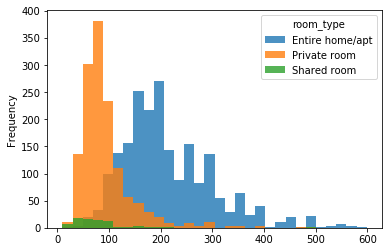

In [51]:
(train.pivot(columns = "room_type", values = "price")
         .plot.hist(bins = 30, stacked = False, alpha = 0.8))

In [52]:
train.groupby("room_type")["price"].mean()

room_type
Entire home/apt    213.848369
Private room        92.080845
Shared room         84.443038
Name: price, dtype: float64

In [53]:
y = train["price"]
train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews", "require_guest_phone_verification",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]

In [54]:
X_num = pd.get_dummies(train_num_cat)

In [55]:
train_text.head()

,name,summary,amenities
0,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin..."


In [56]:
train.amenities = train.amenities.str.replace("[{}]", "")

In [57]:
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [58]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [59]:
amenity_ohe.head(3)

,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1


In [60]:
train["text"] = train["name"].str.cat(train["summary"], sep = " ")

In [61]:
vect = CountVectorizer(stop_words = "english", min_df = 10)
X_text = vect.fit_transform(train["text"])

In [62]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#evaluates rmse on a validation set:
def eval_model(model, X, y, state = 3):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, random_state = state)
    preds = model.fit(X_tr, y_tr).predict(X_val)
    return rmse(y_val, preds)

def pred_val(model, X, y):
    X_train = X[:-1]
    Y_train = y[:-1]
    
    model.fit(X_train, Y_train)
    print(X[-2:-1])
    return model.predict([X[-1]])[0]
    

In [63]:
(X_num.shape, X_text.shape, amenity_ohe.shape)

((3536, 42), (3536, 1100), (3536, 45))

In [64]:
#this is numeric + amenities:
X = np.hstack((X_num, amenity_ohe))

#this is all of them:
X_full = np.hstack((X_num, amenity_ohe, X_text.toarray()))

In [65]:
models_rmse = [eval_model(xgb.XGBRegressor(), X_num, y),
 eval_model(xgb.XGBRegressor(), X, y),
 eval_model(Ridge(), X_num, y),
 eval_model(Ridge(), X, y),
 eval_model(xgb.XGBRegressor(), X_full, y)]

In [66]:
models_rmse = pd.Series(models_rmse, index = ["xgb_num", "xgb_ame", "ridge", "ridge_ame", "xgb_full"] )

In [67]:
models_rmse

xgb_num      58.234924
xgb_ame      56.718376
ridge        60.604902
ridge_ame    58.972657
xgb_full     56.531990
dtype: float64

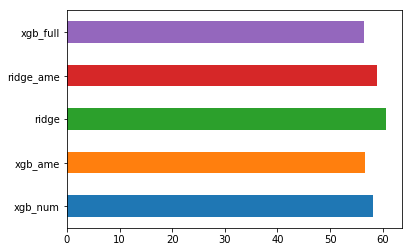

In [68]:
models_rmse.plot(kind = "barh")

In [69]:
results = []
for i in range(30):
    X_tr, X_val, y_tr, y_val = train_test_split(X_num, y)
    y_baseline = [np.mean(y_tr)]*len(y_val)

    model = Ridge(alpha = 5)
    preds_logit = model.fit(X_tr, y_tr).predict(X_val)


    model = xgb.XGBRegressor()  
    preds_xgb = model.fit(X_tr, y_tr).predict(X_val)
    
    results.append((rmse(y_baseline, y_val),
                    rmse(preds_logit, y_val),
                    rmse(preds_xgb, y_val)
                    ))

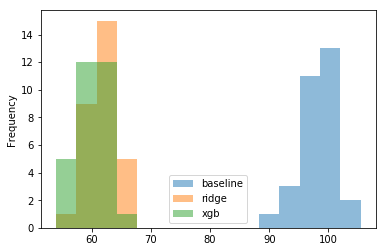

In [70]:
results = pd.DataFrame(results, columns = ["baseline", "ridge", "xgb"])
results.plot.hist(bins = 15, alpha = 0.5)

In [71]:
pd.DataFrame([results.mean(), results.std()])

,baseline,ridge,xgb
0,98.328313,61.724121,60.019511
1,2.855959,2.373654,2.440083
